In [ ]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#Class label names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
# Load Fashion-MNIST
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
# Inspect pixel ranges and label distribution (quick)
print("Pixel min/max before scaling:", X_train.min(), X_train.max())
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u:2d} ({class_names[u]:12s}): {c}")


Pixel min/max before scaling: 0 255
 0 (T-shirt/top ): 6000
 1 (Trouser     ): 6000
 2 (Pullover    ): 6000
 3 (Dress       ): 6000
 4 (Coat        ): 6000
 5 (Sandal      ): 6000
 6 (Shirt       ): 6000
 7 (Sneaker     ): 6000
 8 (Bag         ): 6000
 9 (Ankle boot  ): 6000


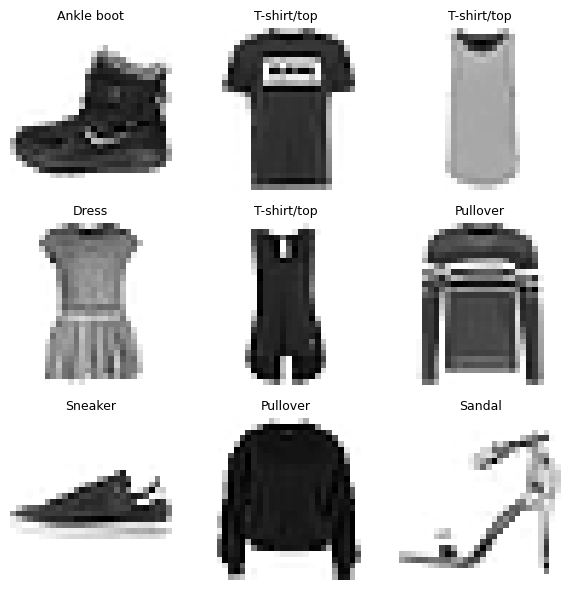

In [ ]:
# Visualize a 3x3 grid of samples
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Scale pixels to [0,1]
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32")  / 255.0

# Create a validation split from the end of training set
VAL = 6000
X_val, y_val = X_train[-VAL:], y_train[-VAL:]
X_train, y_train = X_train[:-VAL], y_train[:-VAL]

X_train.shape, X_val.shape, X_test.shape


((54000, 28, 28), (6000, 28, 28), (10000, 28, 28))

In [ ]:
# Baseline linear classifier
baseline = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation="softmax")
])

baseline.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

hist_baseline = baseline.fit(
    X_train, y_train,
    epochs=10, batch_size=128,
    validation_data=(X_val, y_val),
    verbose=2
)

print("Test performance (baseline):")
baseline.evaluate(X_test, y_test, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
422/422 - 4s - 9ms/step - accuracy: 0.7565 - loss: 0.7526 - val_accuracy: 0.8137 - val_loss: 0.5468
Epoch 2/10
422/422 - 3s - 7ms/step - accuracy: 0.8260 - loss: 0.5224 - val_accuracy: 0.8283 - val_loss: 0.4882
Epoch 3/10
422/422 - 1s - 3ms/step - accuracy: 0.8387 - loss: 0.4799 - val_accuracy: 0.8397 - val_loss: 0.4624
Epoch 4/10
422/422 - 1s - 3ms/step - accuracy: 0.8453 - loss: 0.4574 - val_accuracy: 0.8455 - val_loss: 0.4473
Epoch 5/10
422/422 - 1s - 3ms/step - accuracy: 0.8501 - loss: 0.4429 - val_accuracy: 0.8472 - val_loss: 0.4372
Epoch 6/10
422/422 - 1s - 3ms/step - accuracy: 0.8529 - loss: 0.4324 - val_accuracy: 0.8502 - val_loss: 0.4301
Epoch 7/10
422/422 - 1s - 3ms/step - accuracy: 0.8551 - loss: 0.4245 - val_accuracy: 0.8518 - val_loss: 0.4248
Epoch 8/10
422/422 - 1s - 3ms/step - accuracy: 0.8568 - loss: 0.4182 - val_accuracy: 0.8538 - val_loss: 0.4207
Epoch 9/10
422/422 - 1s - 3ms/step - accuracy: 0.8585 - loss: 0.4130 - val_accuracy: 0.8553 - val_loss: 0.4174
E

[0.45451948046684265, 0.8406999707221985]

In [ ]:
#  MLP with two hidden layers + dropout
mlp = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax")
])

mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

hist_mlp = mlp.fit(
    X_train, y_train,
    epochs=20, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[early],
    verbose=2
)

print("Test performance (MLP):")
mlp.evaluate(X_test, y_test, verbose=0)


Epoch 1/20
422/422 - 6s - 13ms/step - accuracy: 0.7913 - loss: 0.5943 - val_accuracy: 0.8462 - val_loss: 0.4254
Epoch 2/20
422/422 - 6s - 15ms/step - accuracy: 0.8502 - loss: 0.4177 - val_accuracy: 0.8672 - val_loss: 0.3621
Epoch 3/20
422/422 - 4s - 9ms/step - accuracy: 0.8649 - loss: 0.3751 - val_accuracy: 0.8745 - val_loss: 0.3419
Epoch 4/20
422/422 - 5s - 12ms/step - accuracy: 0.8730 - loss: 0.3491 - val_accuracy: 0.8808 - val_loss: 0.3341
Epoch 5/20
422/422 - 6s - 14ms/step - accuracy: 0.8781 - loss: 0.3325 - val_accuracy: 0.8777 - val_loss: 0.3481
Epoch 6/20
422/422 - 4s - 10ms/step - accuracy: 0.8841 - loss: 0.3154 - val_accuracy: 0.8818 - val_loss: 0.3241
Epoch 7/20
422/422 - 7s - 16ms/step - accuracy: 0.8868 - loss: 0.3061 - val_accuracy: 0.8835 - val_loss: 0.3193
Epoch 8/20
422/422 - 4s - 9ms/step - accuracy: 0.8893 - loss: 0.2971 - val_accuracy: 0.8828 - val_loss: 0.3244
Epoch 9/20
422/422 - 5s - 12ms/step - accuracy: 0.8924 - loss: 0.2887 - val_accuracy: 0.8802 - val_loss: 0

[0.34657520055770874, 0.8877000212669373]

In [ ]:
#  Add channel dimension for Conv2D
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn   = X_val[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape


((54000, 28, 28, 1), (6000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
#  A compact CNN
from tensorflow import keras

cnn = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

# Compile
cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

# Early stopping
early_cnn = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

# Train
hist_cnn = cnn.fit(
    X_train_cnn, y_train,
    epochs=10,                  # reduced epochs to avoid long execution
    batch_size=128,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_cnn],
    verbose=2
)

# Evaluate
print("Test performance (CNN):")
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
422/422 - 94s - 222ms/step - accuracy: 0.8129 - loss: 0.5189 - val_accuracy: 0.8732 - val_loss: 0.3315
Epoch 2/10
422/422 - 91s - 216ms/step - accuracy: 0.8857 - loss: 0.3170 - val_accuracy: 0.8977 - val_loss: 0.2704
Epoch 3/10
422/422 - 142s - 336ms/step - accuracy: 0.9010 - loss: 0.2704 - val_accuracy: 0.9082 - val_loss: 0.2475
Epoch 4/10
422/422 - 91s - 215ms/step - accuracy: 0.9129 - loss: 0.2370 - val_accuracy: 0.9157 - val_loss: 0.2363
Epoch 5/10
422/422 - 93s - 220ms/step - accuracy: 0.9225 - loss: 0.2131 - val_accuracy: 0.9175 - val_loss: 0.2315
Epoch 6/10
422/422 - 140s - 333ms/step - accuracy: 0.9292 - loss: 0.1894 - val_accuracy: 0.9207 - val_loss: 0.2243
Epoch 7/10
422/422 - 142s - 335ms/step - accuracy: 0.9371 - loss: 0.1696 - val_accuracy: 0.9177 - val_loss: 0.2359
Epoch 8/10
422/422 - 140s - 332ms/step - accuracy: 0.9420 - loss: 0.1552 - val_accuracy: 0.9238 - val_loss: 0.2199
Epoch 9/10
422/422 - 91s - 215ms/step - accuracy: 0.9490 - loss: 0.1371 - val_accura

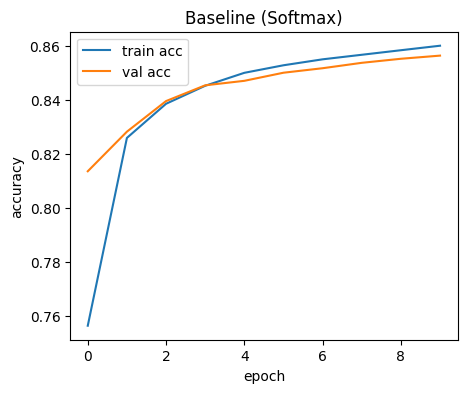

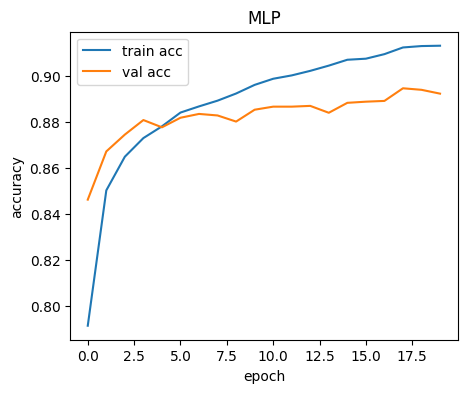

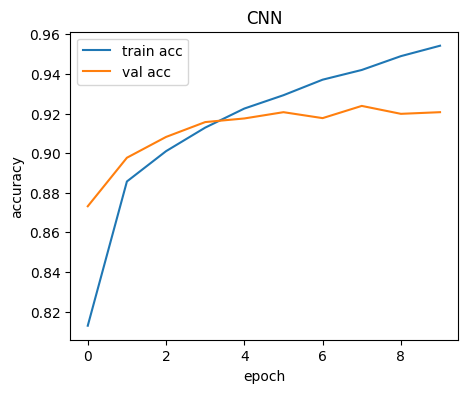

In [ ]:
#  Simple learning-curve plot helper
def plot_history(h, title):
    plt.figure(figsize=(5,4))
    plt.plot(h.history["accuracy"], label="train acc")
    plt.plot(h.history["val_accuracy"], label="val acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

plot_history(hist_baseline, "Baseline (Softmax)")
plot_history(hist_mlp, "MLP")
plot_history(hist_cnn, "CNN")


CNN Test Accuracy: 0.9172


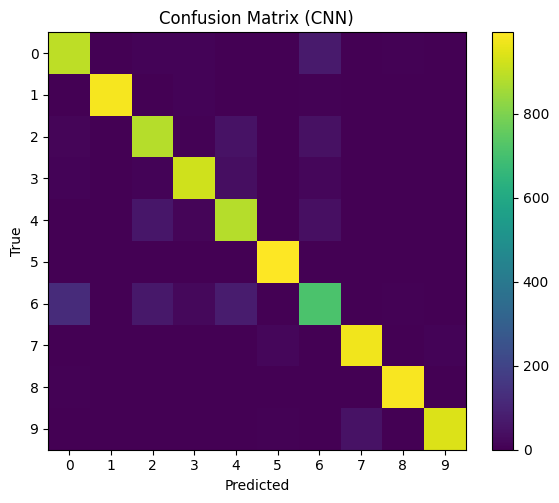

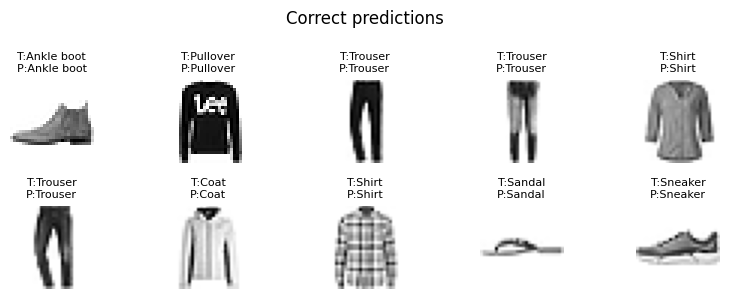

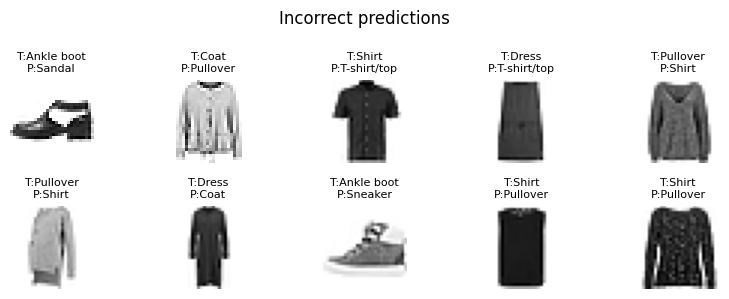

In [ ]:
#  Evaluate best model
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred_probs = cnn.predict(X_test_cnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix with TensorFlow (no sklearn dependency)
cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=10).numpy()

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
plt.tight_layout()
plt.show()

# Show a few correct vs incorrect predictions
def show_examples(indices, title):
    plt.figure(figsize=(8,3))
    for i, idx in enumerate(indices[:10]):
        plt.subplot(2,5,i+1)
        plt.imshow(X_test[idx], cmap='binary')
        plt.title(f"T:{class_names[y_test[idx]]}\nP:{class_names[y_pred[idx]]}", fontsize=8)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

correct_idx = np.where(y_pred == y_test)[0]
wrong_idx   = np.where(y_pred != y_test)[0]

show_examples(correct_idx[:10], "Correct predictions")
show_examples(wrong_idx[:10], "Incorrect predictions")


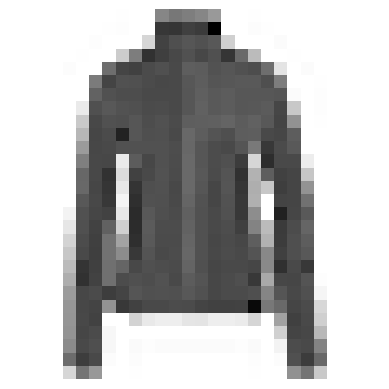

T-shirt/top : 0.000
Trouser     : 0.000
Pullover    : 0.100
Dress       : 0.000
Coat        : 0.874
Sandal      : 0.000
Shirt       : 0.026
Sneaker     : 0.000
Bag         : 0.000
Ankle boot  : 0.000
Predicted: Coat | True: Coat


In [ ]:
#  Predict a single test image
idx = 1234
img = X_test[idx]
plt.imshow(img, cmap='binary')
plt.axis('off')
plt.show()

img_cnn = img[np.newaxis, ..., np.newaxis]
probs = cnn.predict(img_cnn, verbose=0)[0]
pred  = np.argmax(probs)

for i, p in enumerate(probs):
    print(f"{class_names[i]:12s}: {p:.3f}")
print("Predicted:", class_names[pred], "| True:", class_names[y_test[idx]])


In [ ]:
# Save and reload the CNN
cnn.save("fashion_cnn.h5")
reloaded = keras.models.load_model("fashion_cnn.h5")
print("Reloaded model test accuracy:")
reloaded.evaluate(X_test_cnn, y_test, verbose=0)


Reloaded model test accuracy:


[0.23826763033866882, 0.9172000288963318]

In [ ]:
import os

# create 'static' folder if not exists
os.makedirs("static", exist_ok=True)

# now save test images
for i in range(10):
    img = X_test[i]
    plt.imsave(f"static/test{i}.png", img, cmap="gray")


In [ ]:
from flask import Flask, render_template, request
import tensorflow as tf
import numpy as np
from PIL import Image
import os

app = Flask(__name__)

# Load trained model
model = tf.keras.models.load_model("fashion_cnn.h5")
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Home page -> show 10 test images with dropdowns
@app.route("/", methods=["GET", "POST"])
def index():
    images = [f"test{i}.png" for i in range(10)]
    if request.method == "POST":
        user_preds = request.form.getlist("prediction")
        correct = 0
        for i, img_name in enumerate(images):
            # Load image back
            img = Image.open(os.path.join("static", img_name)).convert("L").resize((28,28))
            img = np.array(img)/255.0
            img = img.reshape(1,28,28,1)
            pred = np.argmax(model.predict(img, verbose=0))
            if class_names[pred] == user_preds[i]:
                correct += 1
        accuracy = (correct/len(images))*100
        return render_template("index.html", images=images, class_names=class_names, accuracy=accuracy, user_preds=user_preds)
    return render_template("index.html", images=images, class_names=class_names)

if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)


In [ ]:
!pip install pyngrok


In [ ]:
!ngrok config add-authtoken YOUR_AUTHTOKEN_HERE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok, conf

# Replace with your actual authtoken
ngrok.set_auth_token("31uqen84mEquPAPyFCMsIr0JuPx_2tTqnHwLVzBcvYCDnfYMg")

# Now connect
public_url = ngrok.connect(5000)
print(" * Public URL:", public_url)


 * Public URL: NgrokTunnel: "https://506965f2ad65.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
!pip install flask flask-ngrok


In [ ]:
!pip install flask pyngrok --quiet

from flask import Flask
from pyngrok import ngrok

# Create Flask app
app = Flask(__name__)

@app.route("/")
def home():
    return "🚀 Flask with ngrok is working!"

# Open a tunnel on port 5000
public_url = ngrok.connect(5000)
print("🌍 Public URL:", public_url)

# Run Flask
app.run(port=5000)


🌍 Public URL: NgrokTunnel: "https://06bc9ca836c2.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 12:57:22] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 12:57:23] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
!pip install flask pyngrok


In [ ]:
from flask import Flask, render_template_string
from pyngrok import ngrok

app = Flask(__name__)

# HTML template
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Flask App</title>
</head>
<body>
    <h1>🚀 Flask App is Running!</h1>
    <p>Welcome to your Flask app served via ngrok 🌍</p>
</body>
</html>
"""

@app.route("/")
def home():
    return render_template_string(html_template)

# Start ngrok tunnel & Flask
if __name__ == "__main__":
    # Open an ngrok tunnel to port 5000
    public_url = ngrok.connect(5000)
    print("🌍 Public URL:", public_url)

    # Run Flask app
    app.run(port=5000)


🌍 Public URL: NgrokTunnel: "https://156c826ea3f8.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 13:21:42] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 13:21:43] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
from flask import Flask, render_template_string, request, jsonify
from pyngrok import ngrok
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

app = Flask(__name__)

# HTML template (homepage with file upload forms)
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Flask Fashion App</title>
</head>
<body>
    <h1>🚀 Flask + Fashion-MNIST App</h1>
    <p>Welcome to your Flask app served via ngrok 🌍</p>

    <h2>🔮 Predict Clothing Item</h2>
    <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <button type="submit">Predict</button>
    </form>

    <h2>📊 Evaluate Students' Predictions</h2>
    <form action="/evaluate" method="post" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <button type="submit">Evaluate</button>
    </form>
</body>
</html>
"""

# Load Fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(_, _), (X_test, y_test) = fashion_mnist.load_data()

# Class labels
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Dummy correction map
confusion_map = {
    "Shirt->T-shirt": "T-shirt",
    "Coat->Dress": "Dress"
}

def correct_label(pred_label, true_label):
    key = f"{pred_label}->{true_label}"
    if key in confusion_map:
        return confusion_map[key]
    return pred_label

# Simple ML model (untrained demo — replace with your trained weights if available)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

@app.route("/")
def home():
    return render_template_string(html_template)

@app.route("/predict", methods=["POST"])
def predict():
    file = request.files["file"]
    img = tf.keras.preprocessing.image.load_img(file, color_mode="grayscale", target_size=(28,28))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)  # batch dimension
    preds = model.predict(img_array)
    label = class_names[np.argmax(preds)]
    return jsonify({"prediction": label})

@app.route("/evaluate", methods=["POST"])
def evaluate():
    file = request.files["file"]
    df = pd.read_csv(file)

    results = []
    for idx, row in df.iterrows():
        pred = row["predicted_label"]
        true = class_names[y_test[idx]]
        corrected = correct_label(pred, true)
        results.append({
            "index": int(idx),
            "true_label": true,
            "predicted_label": pred,
            "corrected_label": corrected,
            "was_correct": pred == true,
            "is_correct": corrected == true
        })

    df_res = pd.DataFrame(results)
    acc_before = df_res["was_correct"].mean()
    acc_after = df_res["is_correct"].mean()

    return jsonify({
        "accuracy_before": acc_before,
        "accuracy_after": acc_after,
        "items": results[:10]  # show sample
    })

# Start ngrok + Flask
if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print("🌍 Public URL:", public_url)
    app.run(port=5000)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🌍 Public URL: NgrokTunnel: "https://d7f18dfbcc98.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 13:58:51] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 13:58:53] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras

# Load Fashion-MNIST test set
(_, _), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Class labels
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Create output folder
output_dir = "/mnt/data/fashion_images"
os.makedirs(output_dir, exist_ok=True)

# Save 10 random test images as PNG
np.random.seed(42)
indices = np.random.choice(len(X_test), 10, replace=False)
file_paths = []

for i, idx in enumerate(indices):
    img = X_test[idx]
    label = class_names[y_test[idx]]
    file_path = os.path.join(output_dir, f"img_{i}_{label}.png")
    plt.imsave(file_path, img, cmap="gray")
    file_paths.append(file_path)

print("✅ Images saved:", file_paths)


✅ Images saved: ['/mnt/data/fashion_images/img_0_Shirt.png', '/mnt/data/fashion_images/img_1_Dress.png', '/mnt/data/fashion_images/img_2_T-shirt.png', '/mnt/data/fashion_images/img_3_Sandal.png', '/mnt/data/fashion_images/img_4_Pullover.png', '/mnt/data/fashion_images/img_5_Sandal.png', '/mnt/data/fashion_images/img_6_Ankle boot.png', '/mnt/data/fashion_images/img_7_Sandal.png', '/mnt/data/fashion_images/img_8_Shirt.png', '/mnt/data/fashion_images/img_9_Dress.png']


In [ ]:
import zipfile

# Path for zip file
zip_path = "/mnt/data/fashion_images.zip"

# Create zip
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for file in file_paths:
        zipf.write(file, os.path.basename(file))

print("📂 Zip created at:", zip_path)


📂 Zip created at: /mnt/data/fashion_images.zip


In [ ]:
from flask import Flask, render_template_string, request
from pyngrok import ngrok
import numpy as np
from tensorflow import keras
from PIL import Image

# Flask app
app = Flask(__name__)

# Load Fashion-MNIST model (or your trained model)
model = keras.Sequential([
    keras.layers.Input(shape=(28,28,1)),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Load pretrained weights (if available, otherwise train beforehand)
# model.load_weights("fashion_mnist_model.h5")

# Class labels
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# HTML template
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>🚀 Flask + Fashion-MNIST App</title>
</head>
<body style="font-family: Arial; margin: 40px;">
    <h1>🚀 Flask + Fashion-MNIST App</h1>
    <p>Welcome to your Flask app served via ngrok 🌍</p>

    <h2>🔮 Predict Clothing Item</h2>
    <form method="POST" action="/predict" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <input type="submit" value="Predict">
    </form>

    <h2>📊 Evaluate Students' Predictions</h2>
    <form method="POST" action="/evaluate" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <input type="submit" value="Evaluate">
    </form>
</body>
</html>
"""

@app.route("/")
def home():
    return render_template_string(html_template)

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return "No file uploaded", 400
    file = request.files["file"]
    if file.filename == "":
        return "No selected file", 400

    # Preprocess uploaded image
    img = Image.open(file).convert("L").resize((28, 28))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 28, 28, 1)

    # Model prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Show result in HTML
    return render_template_string("""
        <h1>🔮 Prediction Result</h1>
        <p><b>Predicted Class:</b> {{label}}</p>
        <a href="/">⬅️ Back</a>
    """, label=predicted_class)

# Start ngrok + Flask
if __name__ == "__main__":
    public_url = ngrok.connect(5000)
    print("🌍 Public URL:", public_url)
    app.run(port=5000)


🌍 Public URL: NgrokTunnel: "https://3142cbe9fd86.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 14:06:07] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Aug/2025 14:06:09] "GET /favicon.ico HTTP/1.1" 404 -


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "/mnt/data/fashion_images.zip"
extract_path = "/content/fashion_images"

# Make sure folder exists
os.makedirs(extract_path, exist_ok=True)

# Unzip images
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Images extracted to:", extract_path)
print("📂 Files:", os.listdir(extract_path)[:10])  # show first 10 files


✅ Images extracted to: /content/fashion_images
📂 Files: ['img_4_Pullover.png', 'img_7_Sandal.png', 'img_1_Dress.png', 'img_0_Shirt.png', 'img_6_Ankle boot.png', 'img_9_Dress.png', 'img_2_T-shirt.png', 'img_5_Sandal.png', 'img_8_Shirt.png', 'img_3_Sandal.png']


In [ ]:
# Install dependencies
!pip install flask flask-ngrok tensorflow pillow

# Flask app + ngrok + Fashion-MNIST model
import numpy as np
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import os

# ✅ Train a small Fashion-MNIST model
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=1, validation_data=(x_test, y_test))  # quick 1 epoch for demo

# ✅ Fashion-MNIST label names
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# ✅ Flask app
app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def home():
    return """
    <h1>🚀 Flask + Fashion-MNIST</h1>
    <form action="/predict" method="post" enctype="multipart/form-data">
        <h3>🧠 Predict Clothing Item</h3>
        <input type="file" name="file" />
        <input type="submit" value="Predict" />
    </form>
    """

@app.route("/predict", methods=["POST"])
def predict():
    if "file" not in request.files:
        return "⚠️ No file uploaded"

    file = request.files["file"]
    filepath = os.path.join("/content", file.filename)
    file.save(filepath)

    # Preprocess uploaded image
    img = image.load_img(filepath, target_size=(28,28), color_mode="grayscale")
    img_array = image.img_to_array(img).reshape(1,28,28,1) / 255.0

    # Model prediction
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_name = labels[class_idx]

    return f"✅ Predicted: <b>{class_name}</b> ({pred[0][class_idx]*100:.2f}% confidence)"

if __name__ == "__main__":
    app.run()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8113 - loss: 0.5326 - val_accuracy: 0.8878 - val_loss: 0.3147
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-35:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.12/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
           

In [1]:
def evaluate_model(clf, X_tr, y_tr, X_te, y_te, model_name):
    y_proba = None
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_te)
    elif hasattr(clf, "decision_function"):
        # Convert decision scores to probabilities via softmax-like normalization per class
        # Note: not a calibrated probability; acceptable for a rough AUC comparison if needed
        scores = clf.decision_function(X_te)
        # If binary shape, convert to two-column
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        # Min-max per row to 0..1
        s_min = scores.min(axis=1, keepdims=True)
        s_max = scores.max(axis=1, keepdims=True)
        denom = np.where((s_max - s_min)==0, 1, (s_max - s_min))
        y_proba = (scores - s_min) / denom

    y_pred = clf.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec_macro = precision_score(y_te, y_pred, average='macro', zero_division=0)

    auc_ovr = None
    if y_proba is not None:
        # One-vs-Rest multiclass AUC with macro averaging
        y_true_bin = keras.utils.to_categorical(y_te, num_classes=num_classes)
        try:
            auc_ovr = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
        except Exception:
            auc_ovr = None

    print(f"{model_name} — Accuracy: {acc:.4f} | Macro-Precision: {prec_macro:.4f} | OvR AUC: {auc_ovr if auc_ovr is not None else 'n/a'}")
    return {"model": model_name, "acc": acc, "prec_macro": prec_macro, "auc_ovr": auc_ovr}

results = []

In [4]:
from tensorflow.keras.datasets import fashion_mnist

# 1. Load Fashion MNIST data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# 2. Flatten images (28x28 → 784 features) for models like Logistic Regression / SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)    # (10000, 784)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train set shape: (60000, 28, 28) (60000,)
Test set shape: (10000, 28, 28) (10000,)


In [ ]:
# Use a smaller subset for grid search to speed up tuning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

# Flatten the data for use with Logistic Regression
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_sub, _, y_train_sub, _ = train_test_split(X_train_flat, y_train, train_size=8000, stratify=y_train, random_state=42)
pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False safer for sparse-like; here dense but fine
    ("clf", LogisticRegression(max_iter=200, solver='saga', tol=1e-3, n_jobs=-1))
])

param_lr = {
    "clf__C": [1.0, 0.5, 2.0]
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
grid_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_lr.fit(X_train_sub, y_train_sub)
best_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=200, solver='saga', tol=1e-3, n_jobs=-1, C=grid_lr.best_params_["clf__C"]))
])

print("training full dataset for Logistic Regression")
best_lr.fit(X_train_flat, y_train)
print("LR best params:", grid_lr.best_params_)

# Assuming num_classes is defined elsewhere, otherwise define it here
num_classes = len(np.unique(y_train))

res_lr = evaluate_model(best_lr, X_train_flat, y_train, X_test_flat, y_test, "LogisticRegression")
results.append(res_lr)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


training full dataset for Logistic Regression
